# `grib_to_netcdf` Processing of Continental HRDPS with `cfgrib`

Exploration of doing the processing of the SalishSeaNowcast `grib_to_netcdf` worker
to generate NEMO atmospheric forcing files for SalishSeaCast from the
ECCC MSC 2.5 km rotated lat-lon continental grid HRDPS GRIB2 files using the `cfgrib` package.

`cfgrib`:
* code: https://github.com/ecmwf/cfgrib
* docs in README: https://github.com/ecmwf/cfgrib/blob/master/README.rst
* example in xarray docs: https://docs.xarray.dev/en/stable/examples/ERA5-GRIB-example.html

`conda` environment description for this notebook: `analysis-doug/notebooks/continental-HRDPS/environment-cfgrib.yaml`

This notebook assumes that the MOAD `/results/` file system is mounted.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray

## Load a Single GRIB2 File

In [3]:
grib_dir = Path("/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/")
u_grib = Path("001", "20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H.grib2")
v_grib = Path("001", "20230215T00Z_MSC_HRDPS_VGRD_AGL-10m_RLatLon0.0225_PT001H.grib2")

In [4]:
ds = xarray.open_dataset(grib_dir/u_grib, engine="cfgrib")

ds

<xarray.Dataset>
Dimensions:            (y: 1290, x: 2540)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T18:00 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
ds.close()


## Load u & v Wind Components from the Same Forecast Time Step

It turns out that this is a nice demo of `dask` coming into play,
and the dataset is convenient to compare wind vectors with those from
the HRDPS west product.
In the long run though,
the way that time is recorded in GRIB2 files makes combining variables
at this stage of processing not suitable for our purpose
(foreshadowing.. :-)

In [6]:

ds = xarray.open_mfdataset([grib_dir/u_grib, grib_dir/v_grib], engine="cfgrib")

ds

<xarray.Dataset>
Dimensions:            (y: 1290, x: 2540)
Coordinates:
    time               datetime64[ns] 2023-02-15
    step               timedelta64[ns] 01:00:00
    heightAboveGround  float64 10.0
    latitude           (y, x) float64 dask.array<chunksize=(1290, 2540), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(1290, 2540), meta=np.ndarray>
    valid_time         datetime64[ns] 2023-02-15T01:00:00
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 dask.array<chunksize=(1290, 2540), meta=np.ndarray>
    v10                (y, x) float32 dask.array<chunksize=(1290, 2540), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T18:00 GRIB to CDM+CF via cfgrib-0.9.1...

### Crop Dataset to Out Region of Interest

Later,
we'll do this as a preprocessing operation during dataset loading.
I think that reduces the memory footprint of the dask task graph.

In [7]:
crop_ds = ds.sel(y=slice(300, 490), x=slice(230, 460))

crop_ds

<xarray.Dataset>
Dimensions:            (y: 190, x: 230)
Coordinates:
    time               datetime64[ns] 2023-02-15
    step               timedelta64[ns] 01:00:00
    heightAboveGround  float64 10.0
    latitude           (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
    valid_time         datetime64[ns] 2023-02-15T01:00:00
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 dask.array<chunksize=(190, 230), meta=np.ndarray>
    v10                (y, x) float32 dask.array<chunksize=(190, 230), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T18:00 GRIB to CDM+CF via cfgrib-0.9.1...

No actual need to trigger processing of the dask task graph here;
I just wanted to see the result.

In [8]:
crop_ds.load()

<xarray.Dataset>
Dimensions:            (y: 190, x: 230)
Coordinates:
    time               datetime64[ns] 2023-02-15
    step               timedelta64[ns] 01:00:00
    heightAboveGround  float64 10.0
    latitude           (y, x) float64 47.39 47.39 47.4 ... 52.37 52.38 52.38
    longitude          (y, x) float64 -129.0 -128.9 -128.9 ... -122.1 -122.1
    valid_time         datetime64[ns] 2023-02-15T01:00:00
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 0.171 0.2171 0.2402 ... 0.09031 0.06725
    v10                (y, x) float32 -3.368 -3.46 -3.564 ... 0.9091 0.9091
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T18:00 GRIB to CDM+CF via cfgrib-0.9.1...

### Store the Dataset in a netCDF4 File

In [10]:
encoding = {
    var: {"zlib": True, "complevel": 4}
    for var in crop_ds.data_vars
}
# nc_ds.close()
crop_ds.to_netcdf("~/Desktop/uv_cfgrib.nc", mode="w", encoding=encoding, unlimited_dims=("time",))

In [11]:
ls -lh ~/Desktop/*.nc

-rw-rw-r-- 1 doug doug 943K Mar  6 18:01 /home/doug/Desktop/uv_cfgrib.nc
-rw-rw-r-- 1 doug doug 101M Feb 28 17:32 /home/doug/Desktop/uv_rot_py.nc


### Load and Visualize the netCDF4 Dataset

Note that the `time` and `time_counter[0]` values agree,
but that turns out to be a coincidence
(more foreshadowing... :-)

The wind velocity vectors from the continental GRIB2 files are rotated compared to those
in the HRDPS west dataset because we have not yet transformed the continental
product winds from grid to earth reference.

In [12]:
nc_ds = xarray.open_dataset("~/Desktop/uv_cfgrib.nc")

nc_ds

<xarray.Dataset>
Dimensions:            (y: 190, x: 230)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
    v10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T18:00 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
nc_ds.time.values

numpy.datetime64('2023-02-15T00:00:00.000000000')

In [14]:
west_ds = xarray.open_dataset(
    "/results/forcing/atmospheric/GEM2.5/operational/ops_y2023m02d15.nc"
)

west_ds

<xarray.Dataset>
Dimensions:           (time_counter: 24, y: 266, x: 256)
Coordinates:
  * time_counter      (time_counter) datetime64[ns] 2023-02-15 ... 2023-02-15...
  * x                 (x) float64 0.0 2.5e+03 5e+03 ... 6.35e+05 6.375e+05
  * y                 (y) float64 0.0 2.5e+03 5e+03 ... 6.6e+05 6.625e+05
Data variables: (12/14)
    LHTFL_surface     (time_counter, y, x) float32 ...
    PRATE_surface     (time_counter, y, x) float32 ...
    RH_2maboveground  (time_counter, y, x) float32 ...
    atmpres           (time_counter, y, x) float32 ...
    nav_lat           (y, x) float64 ...
    nav_lon           (y, x) float64 ...
    ...                ...
    qair              (time_counter, y, x) float32 ...
    solar             (time_counter, y, x) float32 ...
    tair              (time_counter, y, x) float32 ...
    therm_rad         (time_counter, y, x) float32 ...
    u_wind            (time_counter, y, x) float32 ...
    v_wind            (time_counter, y, x) float32 ...
Attributes:
    Conventions:          CF-1.0
    History:              Wed Feb 15 07:26:09 2023: ncks -4 -L4 -O /results/f...
    GRIB2_grid_template:  20
    NCO:                  4.7.2

In [15]:
west_ds.time_counter.values[0]

numpy.datetime64('2023-02-15T00:00:00.000000000')

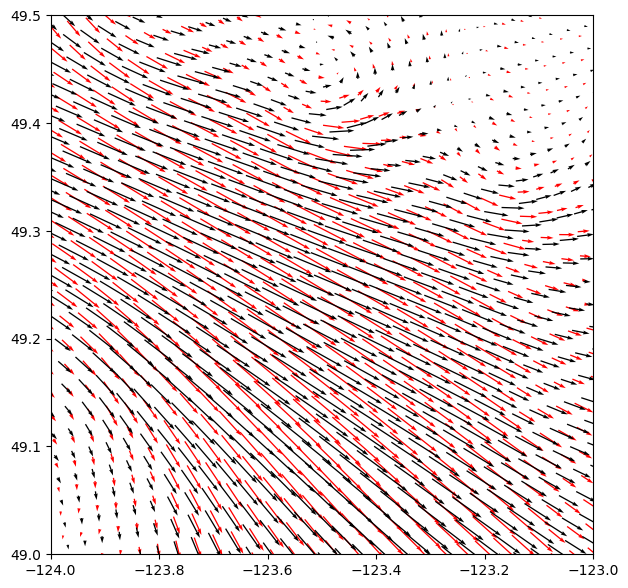

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.quiver(
    nc_ds.longitude, nc_ds.latitude,
    nc_ds.u10, nc_ds.v10,
    scale=100, color="r",
)
ax.quiver(
    west_ds.nav_lon-360, west_ds.nav_lat,
    west_ds.u_wind[0], west_ds.v_wind[0],
    scale=100, 
)
ax.set_ylim(49, 49.5)
ax.set_xlim(236-360, 237-360);

## Load Multiple Variables from a Range of GRIB2 Time Steps

This is where things get more complicated...

But it's also where I discover the power of using a preprocessing function
in `xarray.open_mfdataset()`...

Start with 2 variables (wind components) and 2 GRIB2 time steps:

In [165]:
grib_dir = Path("/results/forcing/atmospheric/continental2.5/GRIB/")
file_tmpl = "{date}T{forecast}Z_MSC_HRDPS_{variable}_RLatLon0.0225_PT{hour}H.grib2"
grib_vars = [
    "UGRD_AGL-10m",  
    "VGRD_AGL-10m",  
    # "DSWRF_Sfc",     
    # "DLWRF_Sfc",     
    # "LHTFL_Sfc",     
    # "TMP_AGL-2m",    
    # "SPFH_AGL-2m",   
    # "RH_AGL-2m",     
    # "APCP_Sfc",      
    # "PRATE_Sfc",     
    # "PRMSL_MSL",     
]
yyyymmdd = arrow.get("2023-02-15").format("YYYYMMDD")
forecast = "00"
keep_coords = ("time", "step", "latitude", "longitude")
ys = slice(300, 490)
xs = slice(230, 460)

In [166]:
grib_files = []
for hr in range(1, 3):
    for var in grib_vars:
        grib_hr_dir = grib_dir / Path(yyyymmdd, forecast, f"{hr:03d}")
        grib_file = file_tmpl.format(date=yyyymmdd, forecast=forecast, variable=var, hour=f"{hr:03d}")
        grib_files.append(grib_hr_dir/grib_file)

len(grib_files), grib_files

(4,
 [PosixPath('/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/001/20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H.grib2'),
  PosixPath('/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/001/20230215T00Z_MSC_HRDPS_VGRD_AGL-10m_RLatLon0.0225_PT001H.grib2'),
  PosixPath('/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/002/20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT002H.grib2'),
  PosixPath('/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/002/20230215T00Z_MSC_HRDPS_VGRD_AGL-10m_RLatLon0.0225_PT002H.grib2')])

Passing this function via the `preprocess` arg in `xarray.open_mfdataset()`
reduces the size of the dask tasks
(I think)
by getting rid of data items we don't need as early as possible in the processing.

In [167]:
def _crop_domain(ds):
    # Select region of interest
    ds = ds.sel(y=slice(300, 490), x=slice(230, 460))
    # Drop coordinates that we don't need
    ds = ds.reset_coords(
        [coord for coord in ds.coords if coord not in keep_coords],
        drop=True,
    )
    return ds

In [168]:
ds = xarray.open_mfdataset(
    grib_files, 
    preprocess=_crop_domain,
    combine="nested", concat_dim="step", 
    engine="cfgrib",
)

ds

<xarray.Dataset>
Dimensions:    (step: 4, y: 190, x: 230)
Coordinates:
    time       datetime64[ns] 2023-02-15
  * step       (step) timedelta64[ns] 01:00:00 01:00:00 02:00:00 02:00:00
    latitude   (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    u10        (step, y, x) float32 dask.array<chunksize=(2, 190, 230), meta=np.ndarray>
    v10        (step, y, x) float32 dask.array<chunksize=(3, 190, 230), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-07T08:35 GRIB to CDM+CF via cfgrib-0.9.1...

Here we learn that GRIB2 stores time values in 2 coordinates,
`time` and `step`.
That means that we end up with 4 `step` coordinate values for 2 time steps
of 2 variables - not what we want:

In [169]:
print(ds.time.data)
print(ds.step.data)

2023-02-15T00:00:00.000000000
[3600000000000 3600000000000 7200000000000 7200000000000]


### Not Sure How to Title This

After a lot of messing around I arrived at the workflow of:
1. Create a dataset for each variable from the relevant time steps of
   each GRIB2 forecast,
   calculating the NEMO-ish `time_counter` value from the `time` and `step`
   coordinate values
2. Give that dataset the variable and coordinate names we want in the NEMO
   forcing dataset
3. Concatenate the GRIB2 forecast datasets in the correct order to produce
   a time series dataset for each variable
4. Combine the variable time series datasets

Below is the proof of principle for the workflow.
Functions to make it cleaner come later.

In [137]:
u10_nemo = xarray.DataArray(
    data=ds.u10.data,
    coords={
        "time_counter": ds.step.values + ds.time.values,
        "y": ds.y,
        "x": ds.x,
    },
    attrs=ds.u10.attrs,
)

u10_nemo

<xarray.DataArray 'concatenate-dcb426a0e9a066e3538db266e87a5921' (
                                                                  time_counter: 2,
                                                                  y: 190, x: 230)>
dask.array<concatenate, shape=(2, 190, 230), dtype=float32, chunksize=(1, 190, 230), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2023-02-15T01:00:00 2023-02-1...
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 182 183 184 185 186 187 188 189
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 222 223 224 225 226 227 228 229
Attributes: (12/32)
    GRIB_paramId:                             165
    GRIB_dataType:                            af
    GRIB_numberOfPoints:                      3276600
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre U wind component
    GRIB_shortName:                           10u
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            eastward_wind

In [154]:
ds1 = xarray.Dataset(
    data_vars={
        "u10": u10_nemo,
    },
    coords={
        "time_counter": ds.step.data + ds.time.data,
        "y": ds.y,
        "x": ds.x,
        "longitude": (["y", "x"], ds.longitude.data),
        "latitude": (["y", "x"], ds.latitude.data),
    },
    attrs=ds.attrs,
)

ds1

<xarray.Dataset>
Dimensions:       (time_counter: 2, y: 190, x: 230)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2023-02-15T01:00:00 2023-02-1...
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 182 183 184 185 186 187 188 189
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 222 223 224 225 226 227 228 229
    longitude     (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
    latitude      (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
Data variables:
    u10           (time_counter, y, x) float32 dask.array<chunksize=(1, 190, 230), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T20:16 GRIB to CDM+CF via cfgrib-0.9.1...

In [157]:
ds_v = xarray.open_mfdataset(
    grib_files, 
    preprocess=_crop_domain,
    combine="nested", concat_dim="step", 
    engine="cfgrib",
)

ds_v

<xarray.Dataset>
Dimensions:    (step: 2, y: 190, x: 230)
Coordinates:
    time       datetime64[ns] 2023-02-15
  * step       (step) timedelta64[ns] 01:00:00 02:00:00
    latitude   (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    v10        (step, y, x) float32 dask.array<chunksize=(1, 190, 230), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T21:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [159]:
v10_nemo = xarray.DataArray(
    data=ds_v.v10.data,
    coords={
        "time_counter": ds_v.step.values + ds_v.time.values,
        "y": ds_v.y,
        "x": ds_v.x,
    },
    attrs=ds_v.v10.attrs,
)

v10_nemo

<xarray.DataArray 'concatenate-67c116b0309713e07c9a70356bdb09fc' (
                                                                  time_counter: 2,
                                                                  y: 190, x: 230)>
dask.array<concatenate, shape=(2, 190, 230), dtype=float32, chunksize=(1, 190, 230), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2023-02-15T01:00:00 2023-02-1...
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 182 183 184 185 186 187 188 189
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 222 223 224 225 226 227 228 229
Attributes: (12/32)
    GRIB_paramId:                             166
    GRIB_dataType:                            af
    GRIB_numberOfPoints:                      3276600
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre V wind component
    GRIB_shortName:                           10v
    GRIB_units:                               m s**-1
    long_name:                                10 metre V wind component
    units:                                    m s**-1
    standard_name:                            northward_wind

In [160]:
ds2 = xarray.Dataset(
    data_vars={
        "v10": v10_nemo,
    },
    coords={
        "time_counter": ds_v.step.data + ds_v.time.data,
        "y": ds_v.y,
        "x": ds_v.x,
        "longitude": (["y", "x"], ds_v.longitude.data),
        "latitude": (["y", "x"], ds_v.latitude.data),
    },
    attrs=ds_v.attrs,
)

ds2

<xarray.Dataset>
Dimensions:       (time_counter: 2, y: 190, x: 230)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2023-02-15T01:00:00 2023-02-1...
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 182 183 184 185 186 187 188 189
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 222 223 224 225 226 227 228 229
    longitude     (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
    latitude      (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
Data variables:
    v10           (time_counter, y, x) float32 dask.array<chunksize=(1, 190, 230), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-06T21:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [162]:
xarray.combine_by_coords([ds1, ds2], combine_attrs="drop_conflicts")

<xarray.Dataset>
Dimensions:       (time_counter: 2, y: 190, x: 230)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2023-02-15T01:00:00 2023-02-1...
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 182 183 184 185 186 187 188 189
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 222 223 224 225 226 227 228 229
    longitude     (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
    latitude      (y, x) float64 dask.array<chunksize=(190, 230), meta=np.ndarray>
Data variables:
    u10           (time_counter, y, x) float32 dask.array<chunksize=(1, 190, 230), meta=np.ndarray>
    v10           (time_counter, y, x) float32 dask.array<chunksize=(1, 190, 230), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal